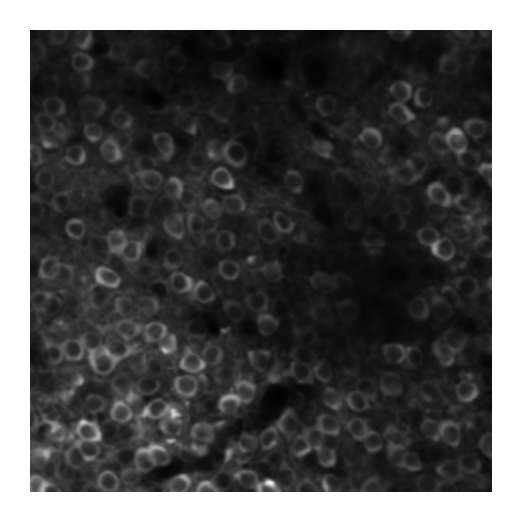

In [1]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
#%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io

# I will download images from website
urls = ['http://www.cellpose.org/static/images/img02.png',
        'http://www.cellpose.org/static/images/img03.png',
        'http://www.cellpose.org/static/images/img05.png']
files = []
for url in urls:
    parts = urlparse(url)
    filename = os.path.basename(parts.path)
    if not os.path.exists(filename):
        sys.stderr.write('Downloading: "{}" to {}\n'.format(url, filename))
        utils.download_url_to_file(url, filename)
    files.append(filename)

# REPLACE FILES WITH YOUR IMAGE PATHS
# files = ['img0.tif', 'img1.tif']

# view 1 image
img = io.imread(files[-1])
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.axis('off')
plt.show()

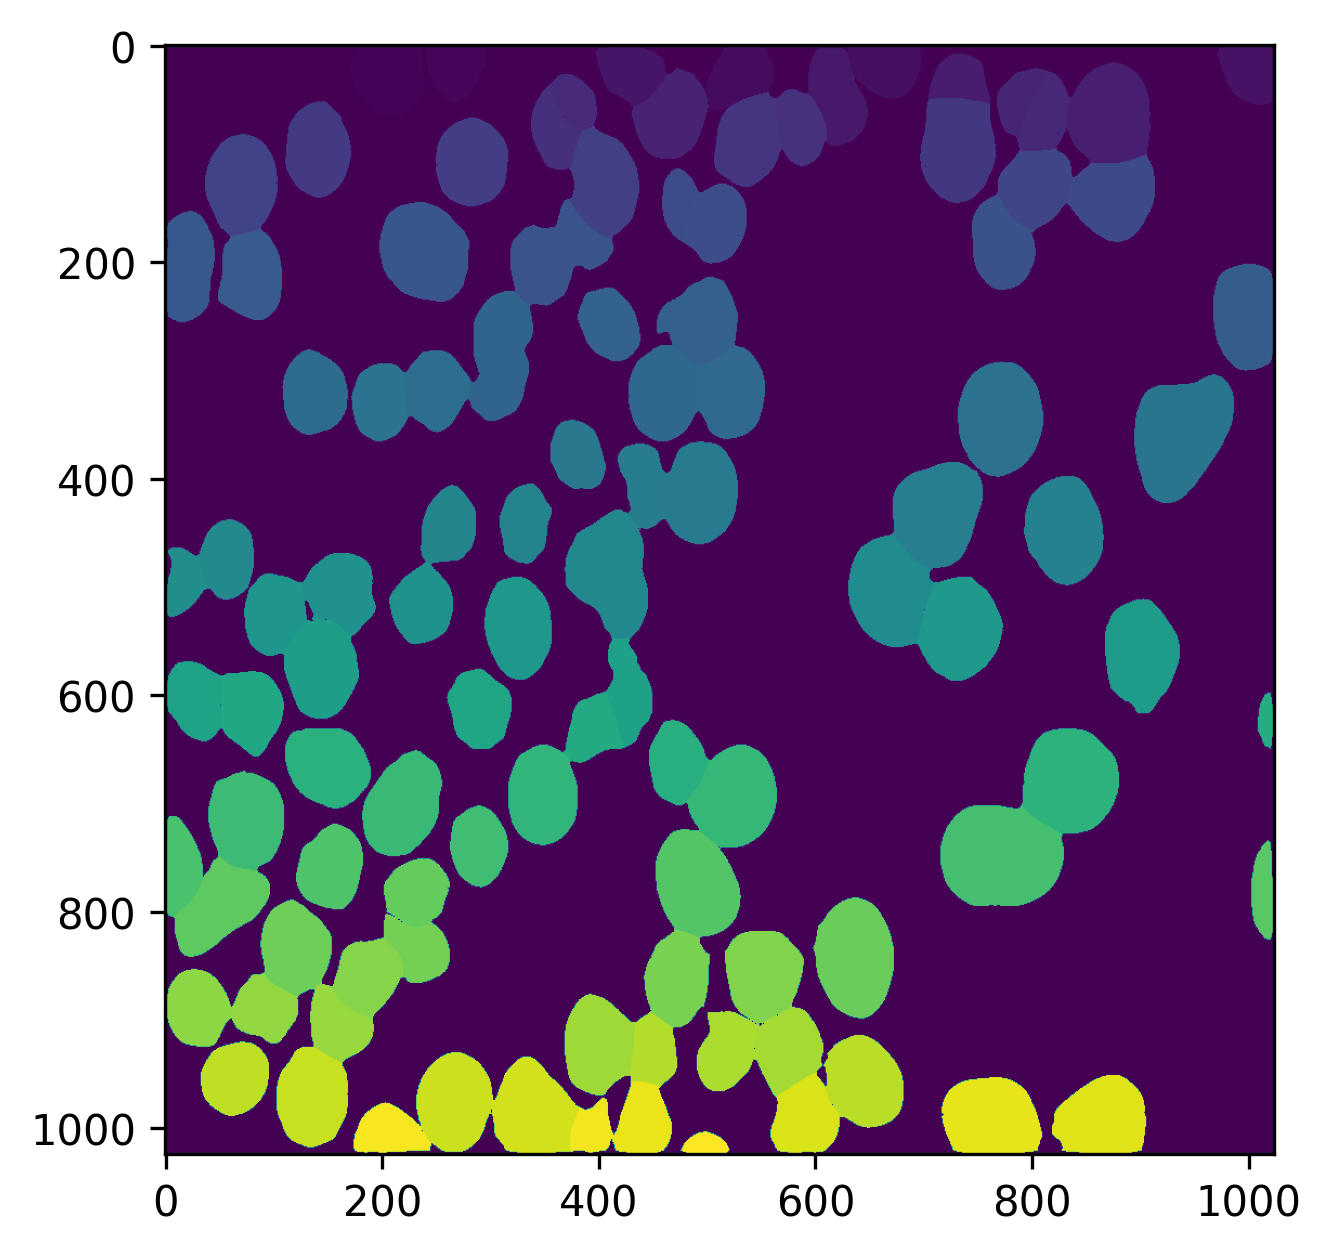

In [64]:
# RUN CELLPOSE
import cv2
from cellpose import models, io

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=False, model_type='cyto')


filename = "test-gs.png"
img = io.imread(filename)
masks, flows, styles, diams = model.eval(img, diameter=None, channels=[0,0])
plt.imshow(masks)
plt.show()

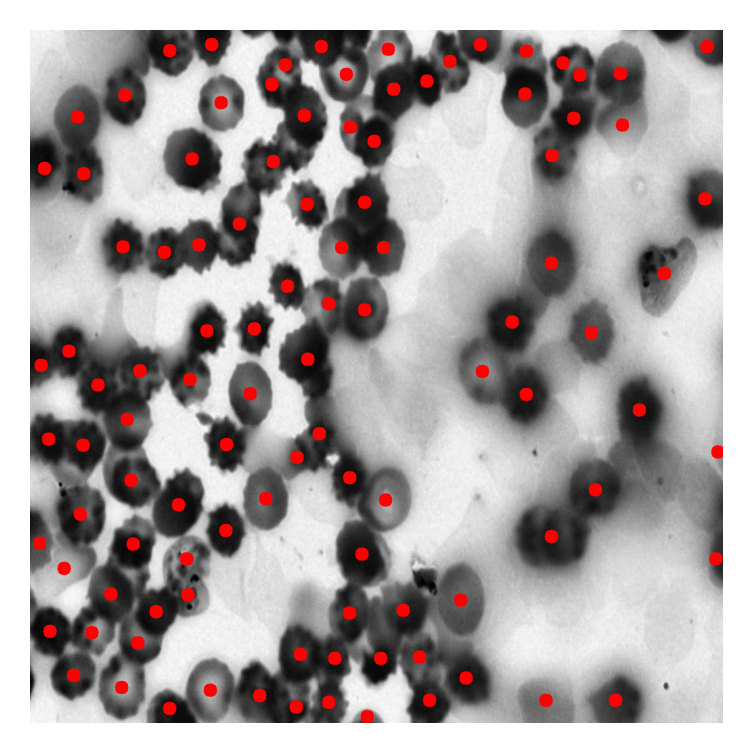

In [107]:
colors = np.unique(masks)
imgz = np.zeros(img.shape[:2])

img2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for c in colors[1:]:
    imgz = masks == c
    imgz= imgz.astype(np.uint8)
    cnts, _ = cv2.findContours(imgz, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    for c in cnts:
        M = cv2.moments(c)
        if M['m00'] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
            cv2.circle(img2, (cX, cY), 10, (255, 0, 0), -1)
        
plt.figure(figsize=(3,3))
plt.axis('off')
plt.imshow(img2)
plt.show()

Number of contours = 75


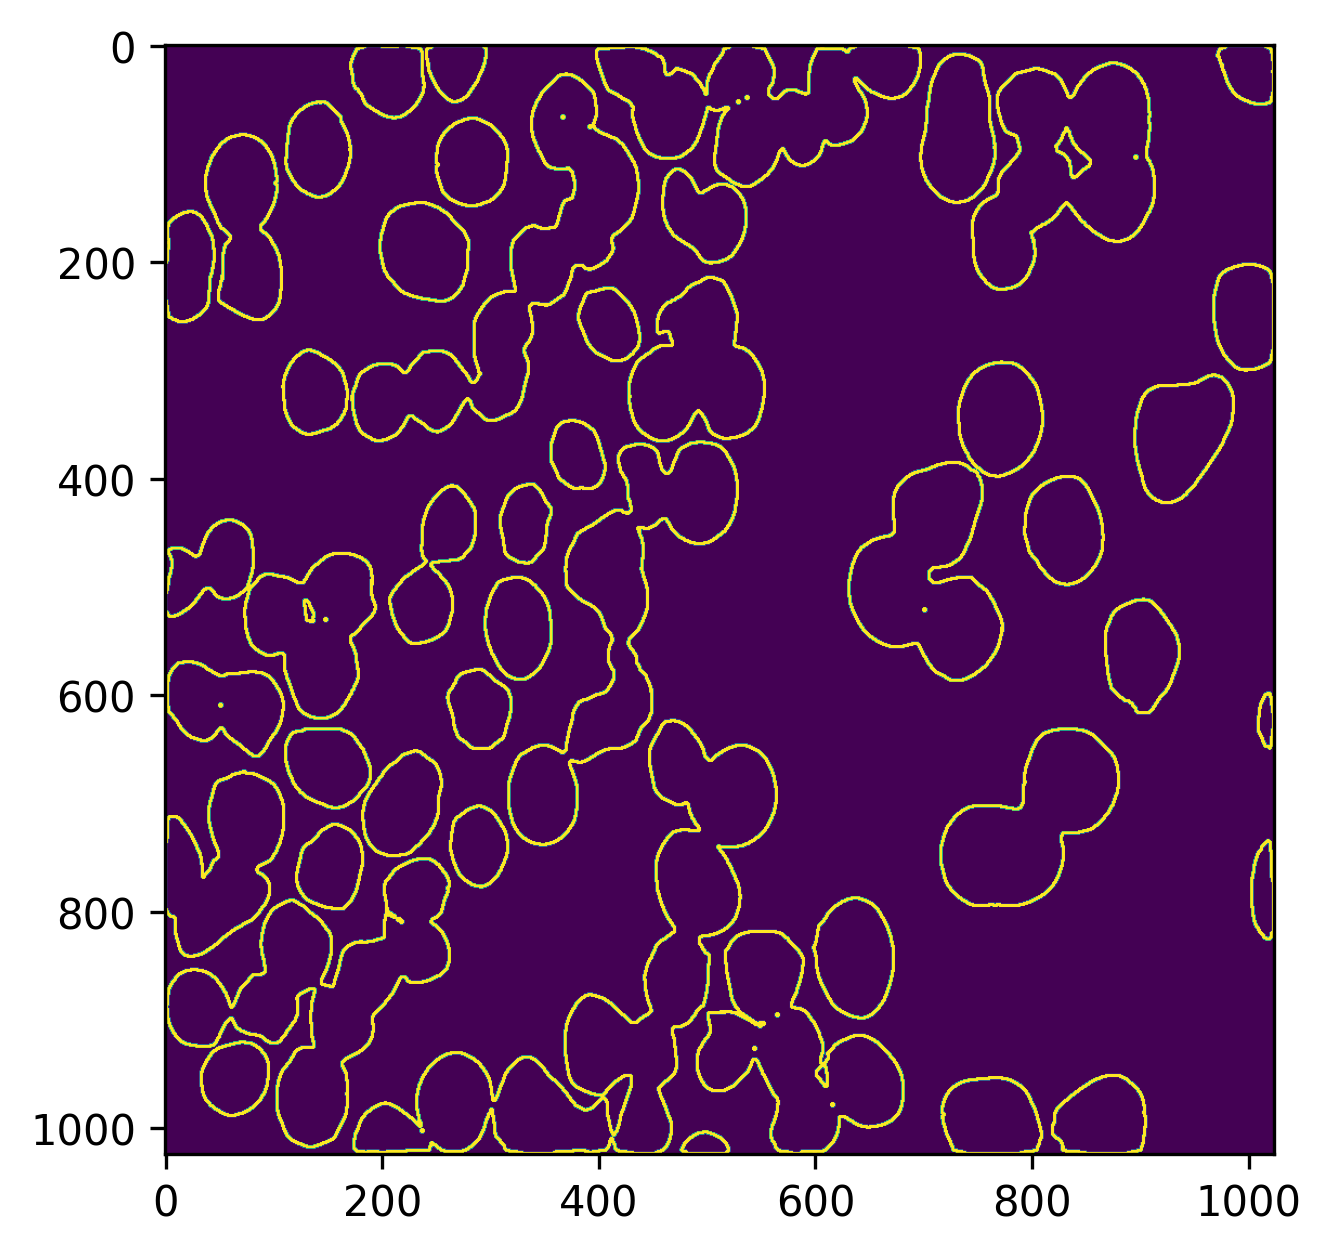

In [70]:
#imgray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)
imgray = masks.astype(np.uint8)
ret, thresh = cv2.threshold(imgray, 0, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
print("Number of contours = {}".format(str(len(contours))))
#print('contours {}'.format(contours[0]))

imgz = np.zeros_like(img)

cv2.drawContours(imgz, contours, -1, 255, 2)
#cv2.drawContours(imgray, contours, -1, (0, 255, 0), 3)

plt.imshow(imgz)
plt.show()
#plt.imshow(imgray)
#plt.show()

In [30]:
conn = cv2.connectedComponentsWithStats(masks, 8, cv2.CV_32S)
num_labels = conn[0]
labels = conn[1]
stats = conn[2]
centroids = conn[3]

for l in labels:
    mask = np.array(labels, dtype=np.uint8)
    mask[labels==l] = 255 

    mean_label = cv2.mean(masks, mask)
    print(mean_label)

error: OpenCV(4.8.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\connectedcomponents.cpp:5632: error: (-215:Assertion failed) iDepth == CV_8U || iDepth == CV_8S in function 'cv::connectedComponents_sub1'


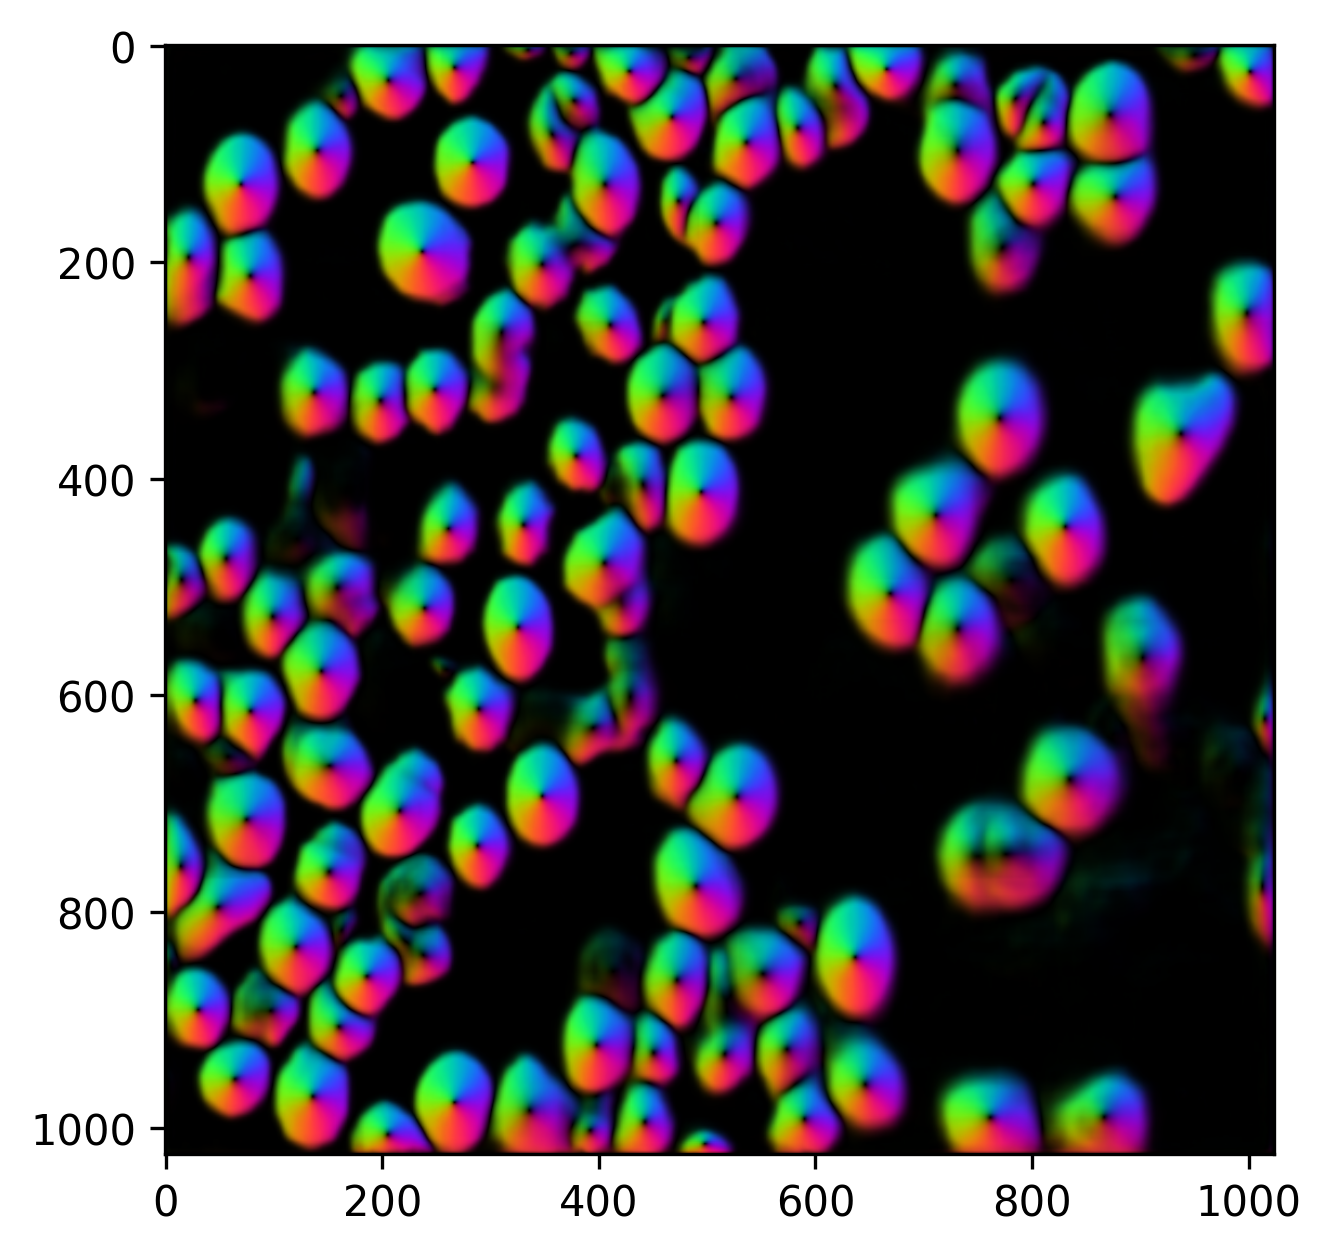

In [25]:
flows[0].shape
plt.imshow(flows[0])
plt.show()

> c:\users\alan_\appdata\local\temp\ipykernel_11484\3643131511.py(39)<module>()

ipdb> masks
array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ..., 96, 96, 96],
       [ 0,  0,  0, ..., 96, 96, 96],
       [ 0,  0,  0, ...,  0, 96, 96]], dtype=uint16)
ipdb> len(masks)
349
ipdb> img.shape
(349, 467, 3)
ipdb> np
<module 'numpy' from 'C:\\Users\\alan_\\.conda\\envs\\cellpose\\lib\\site-packages\\numpy\\__init__.py'>
ipdb> test = np.zeros_like(img.shape[:2])
ipdb> test.shape
(2,)
ipdb> img.shape[:2]
(349, 467)
ipdb> test = np.zeros(img.shape[:2])
ipdb> test.shape
(349, 467)
ipdb> masks[0].shape
(467,)
ipdb> masks.shape
(349, 467)
ipdb> plt.imshow(masks)
ipdb> plt.show()


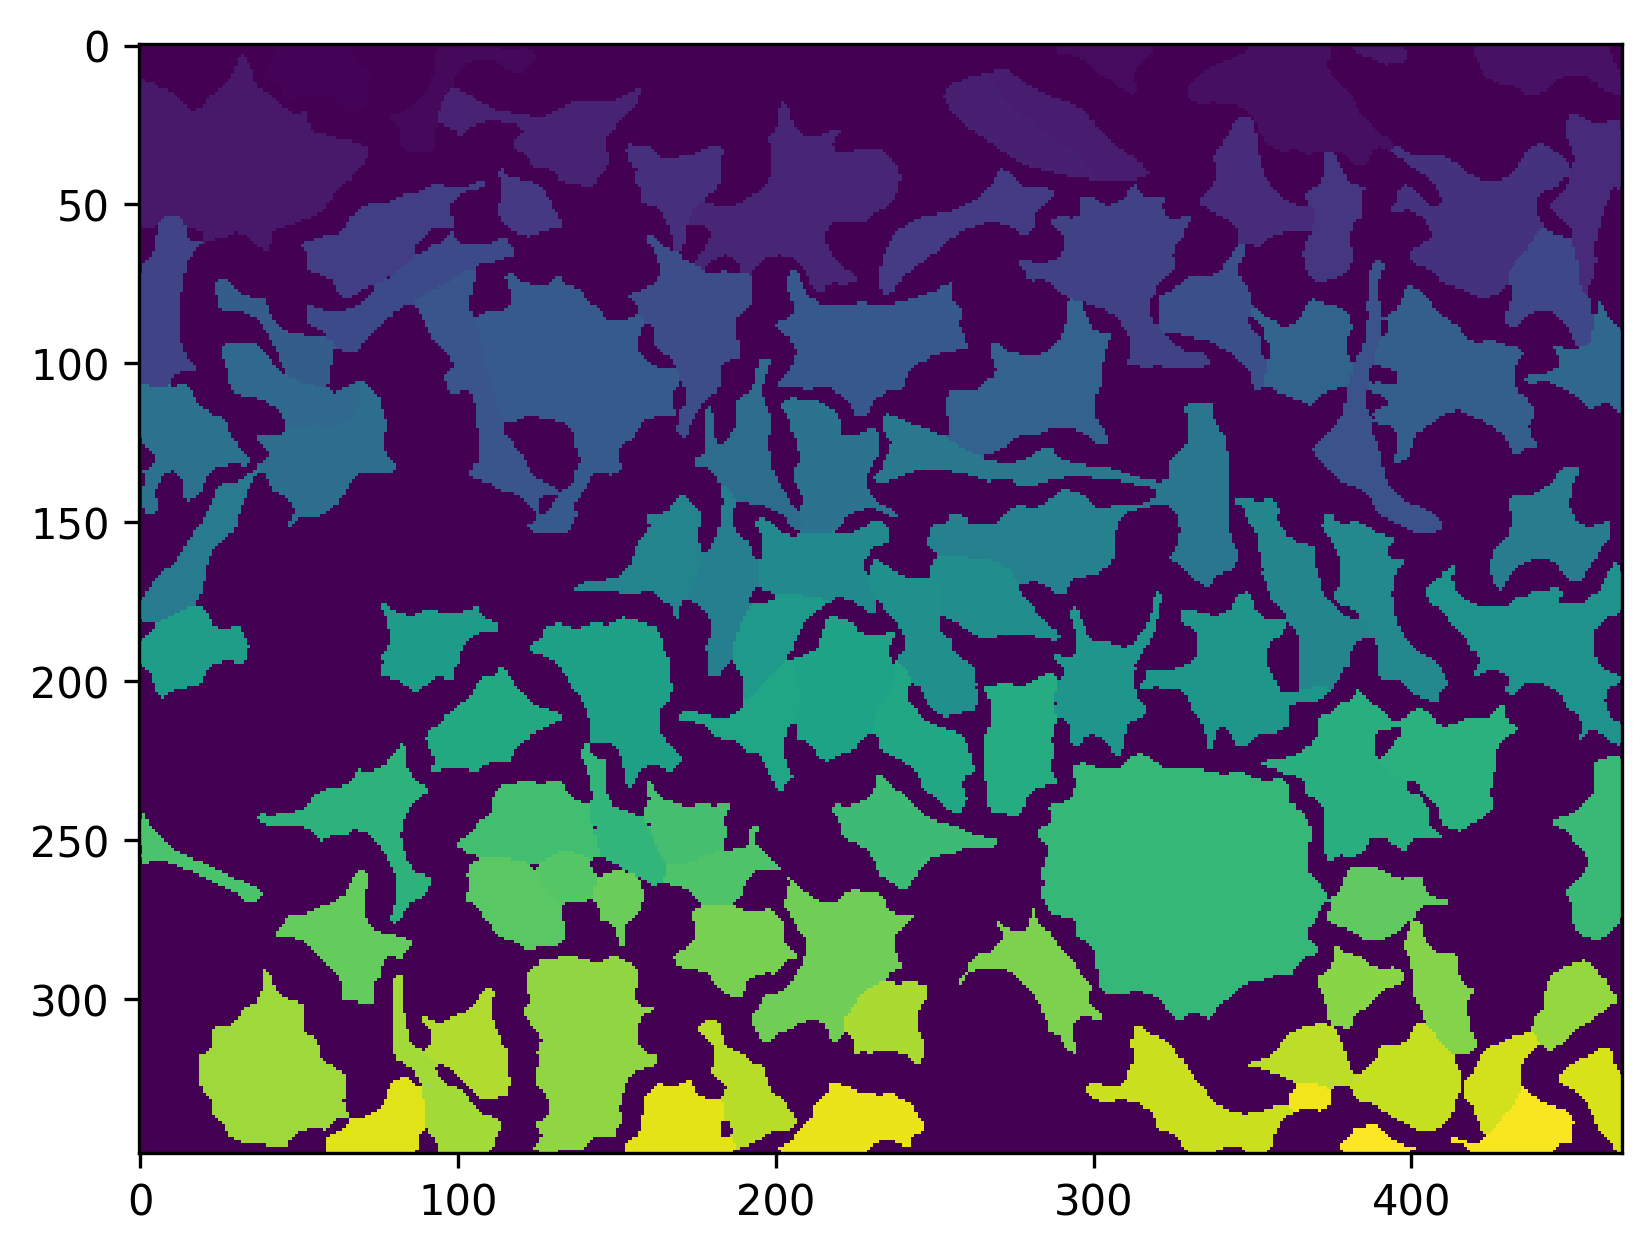

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
ipdb> c


KeyboardInterrupt: 

In [4]:
# RUN CELLPOSE
import cv2
from cellpose import models, io

# DEFINE CELLPOSE MODEL
# model_type='cyto' or model_type='nuclei'
model = models.Cellpose(gpu=False, model_type='cyto')

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
channels = [[2,3], [0,0], [0,0]]

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images

# you can run all in a list e.g.
# >>> imgs = [io.imread(filename) in for filename in files]
# >>> masks, flows, styles, diams = model.eval(imgs, diameter=None, channels=channels)
# >>> io.masks_flows_to_seg(imgs, masks, flows, diams, files, channels)
# >>> io.save_to_png(imgs, masks, flows, files)

# or in a loop
for chan, filename in zip(channels, files):
    img = io.imread(filename)
    masks, flows, styles, diams = model.eval(img, diameter=None, channels=chan)
    
    test = np.zeros(img.shape[:2])
    
    

    import pdb;pdb.set_trace();
    # save results so you can load in gui
    io.masks_flows_to_seg(img, masks, flows, diams, filename, chan)

    # save results as png
    io.save_to_png(img, masks, flows, filename)

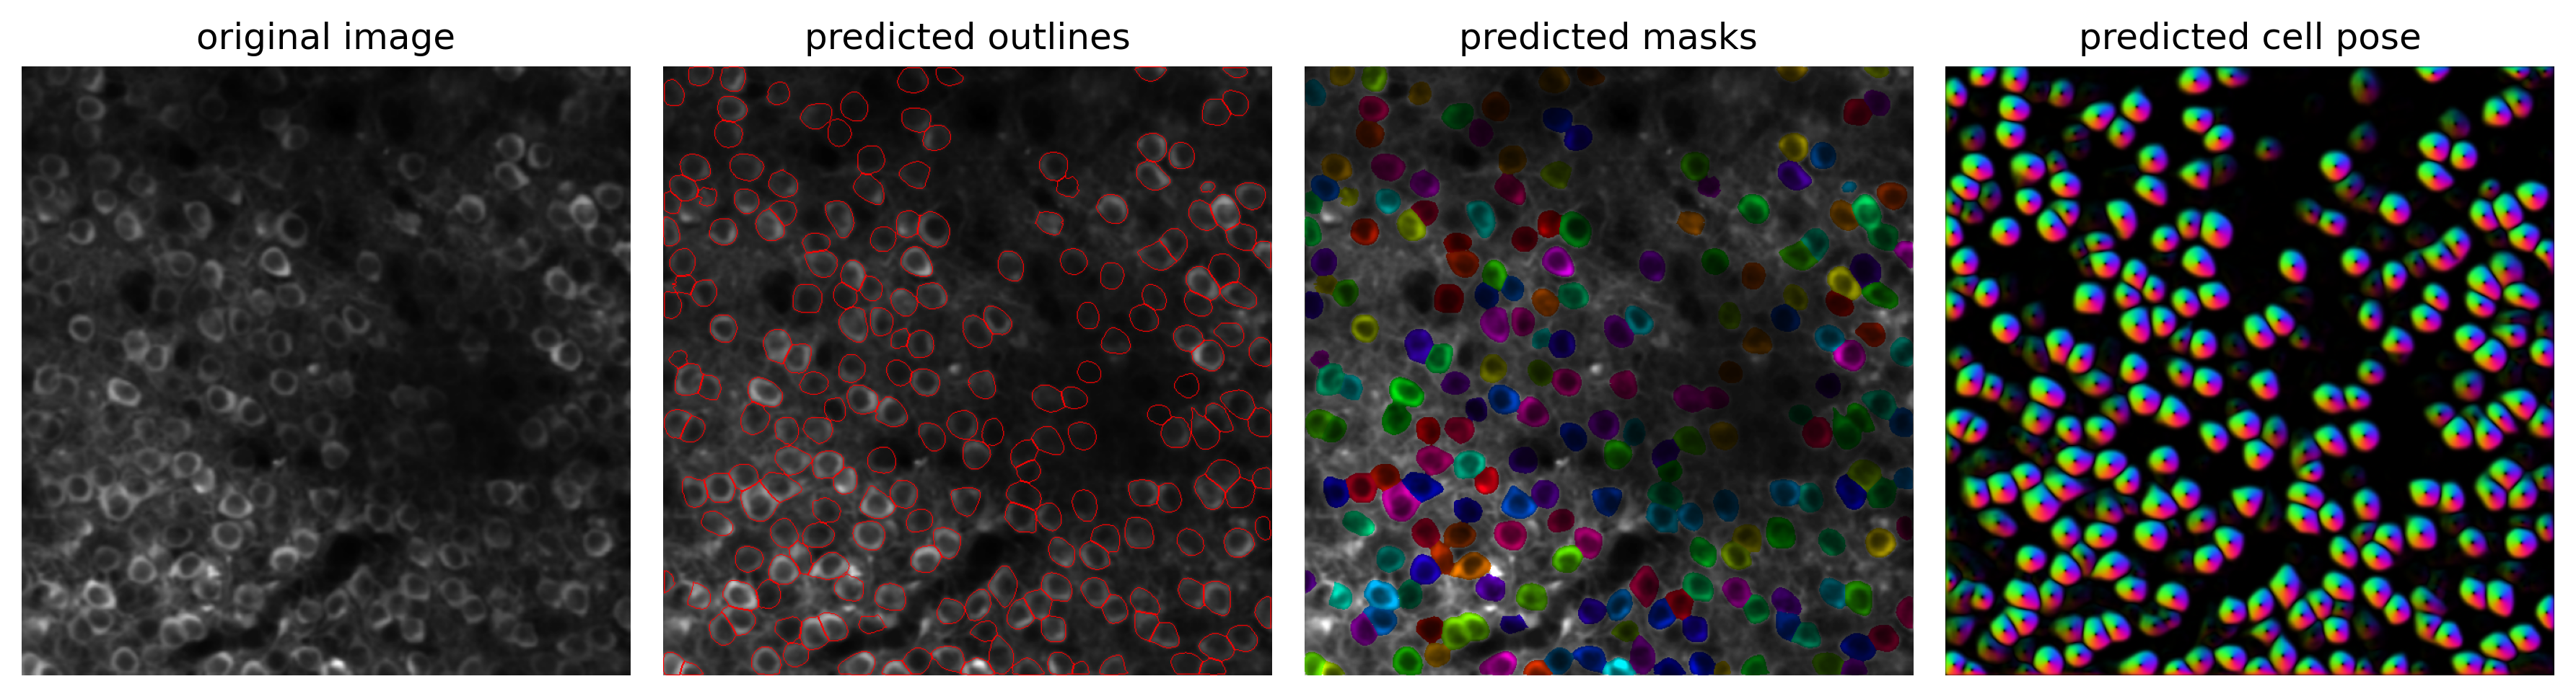

In [3]:
# DISPLAY RESULTS
from cellpose import plot

fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img, masks, flows[0], channels=chan)
plt.tight_layout()
plt.show()